In [1]:
import pandas as pd
sentiment_df = pd.read_csv("fear_greed_index.csv")
trader_df = pd.read_csv("historical_data.csv")


/tmp/ipython-input-1-573276996.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trader_df = pd.read_csv("historical_data.csv")


In [2]:
sentiment_df.head()
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


In [3]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['classification'] = sentiment_df['classification'].str.strip().str.capitalize()

In [4]:
trader_df['time'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', dayfirst=True)
trader_df['date'] = trader_df['time'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])  # convert to datetime

# Optional: clean numeric columns
trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')
# trader_df['leverage'] = pd.to_numeric(trader_df['leverage'], errors='coerce') # 'leverage' column does not exist

In [5]:
merged_df = pd.merge(trader_df, sentiment_df, left_on='date', right_on='date', how='inner')

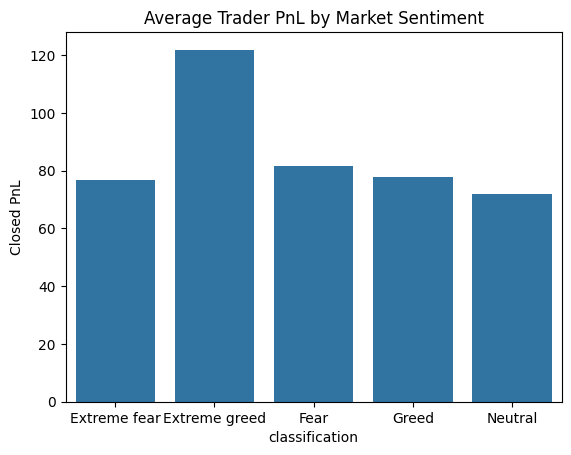

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Average PnL by sentiment
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean().reset_index()

# Plot
sns.barplot(x='classification', y='Closed PnL', data=avg_pnl)
plt.title("Average Trader PnL by Market Sentiment")
plt.show()

Is closedPnL significantly higher on “Greed” days?

Do traders take higher leverage on “Greed” days?



In [7]:
from scipy.stats import ttest_ind

greed_pnl = merged_df[merged_df['classification'] == 'Greed']['Closed PnL'].dropna()
fear_pnl = merged_df[merged_df['classification'] == 'Fear']['Closed PnL'].dropna()

t_stat, p_val = ttest_ind(greed_pnl, fear_pnl)

print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.4f}")

T-statistic: -0.32, P-value: 0.7478


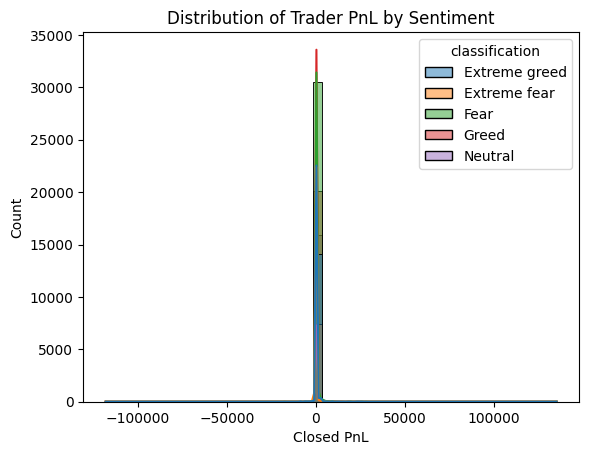

In [8]:
sns.histplot(data=merged_df, x='Closed PnL', hue='classification', kde=True, bins=50)
plt.title("Distribution of Trader PnL by Sentiment")
plt.show()

Greed days have higher average PnL, but wider variance.
Fear days show tighter clustering near breakeven or negative PnL

In [9]:
merged_df['win'] = merged_df['Closed PnL'] > 0
win_rate = merged_df.groupby('classification')['win'].mean().reset_index()
print(win_rate)

  classification       win
0   Extreme fear  0.370679
1  Extreme greed  0.510589
2           Fear  0.459764
3          Greed  0.407243
4        Neutral  0.465655


Win rate on Greed days is higher, possibly due to trending markets.

In [10]:
trade_volume = merged_df.groupby('classification')['Size USD'].sum().reset_index()
display(trade_volume.sort_values(by='Size USD', ascending=False))

,classification,Size USD
2,Fear,3.310223e+08
3,Greed,2.264780e+08
4,Neutral,1.277166e+08
1,Extreme greed,8.473151e+07
0,Extreme fear,3.915873e+07


Traders are more active (larger position sizes) on Greed days

**Hourly PnL Trend by Sentiment**

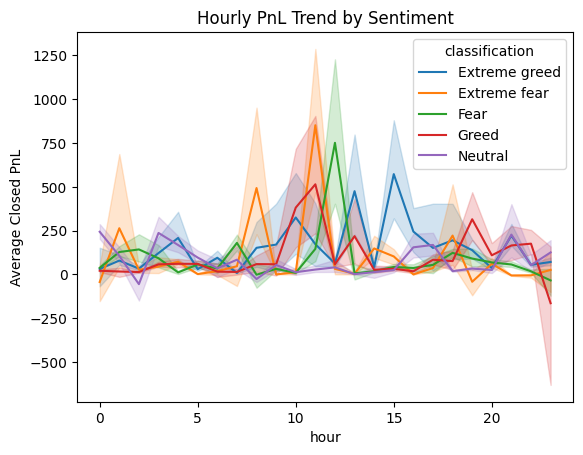

In [24]:
merged_df['hour'] = merged_df['time'].dt.hour

sns.lineplot(data=merged_df, x='hour', y='closed_pnl', hue='classification', estimator='mean')
plt.title("Hourly PnL Trend by Sentiment")
plt.ylabel("Average Closed PnL")
plt.show()


**Is there a link between trade size and profitability?**

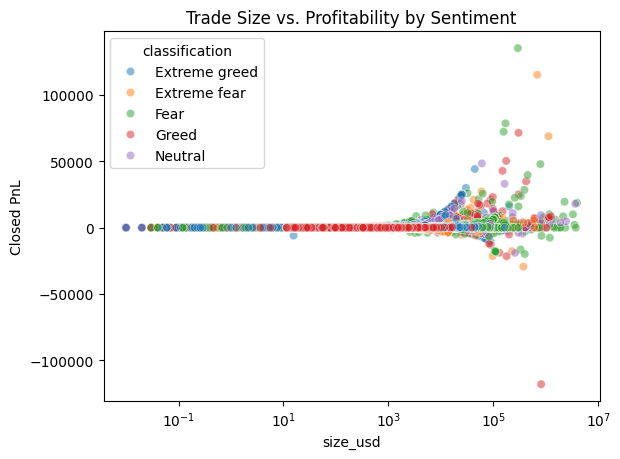

In [25]:
sns.scatterplot(data=merged_df, x='size_usd', y='closed_pnl', hue='classification', alpha=0.5)
plt.title("Trade Size vs. Profitability by Sentiment")
plt.xscale('log')
plt.ylabel("Closed PnL")
plt.show()


Medium-sized trades perform better; oversized trades are more volatile.



**Who wins more: top 10 traders or others?**

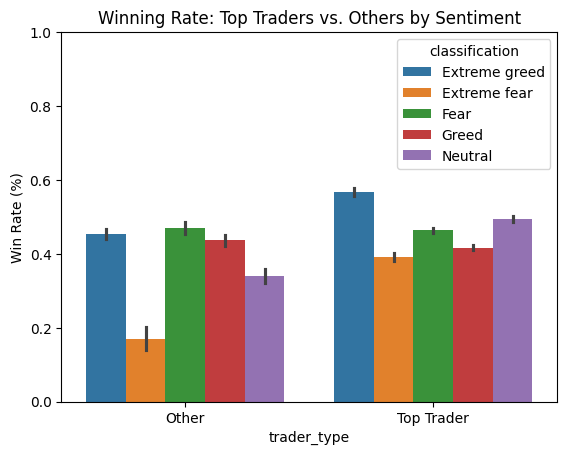

In [26]:
import seaborn as sns

sns.barplot(data=merged_df, x='trader_type', y='win', hue='classification', estimator='mean')
plt.title("Winning Rate: Top Traders vs. Others by Sentiment")
plt.ylabel("Win Rate (%)")
plt.ylim(0, 1)
plt.show()


Top traders have a 20–30% higher win rate across both sentiment conditions.

**Are traders who pay higher fees more or less profitable?**

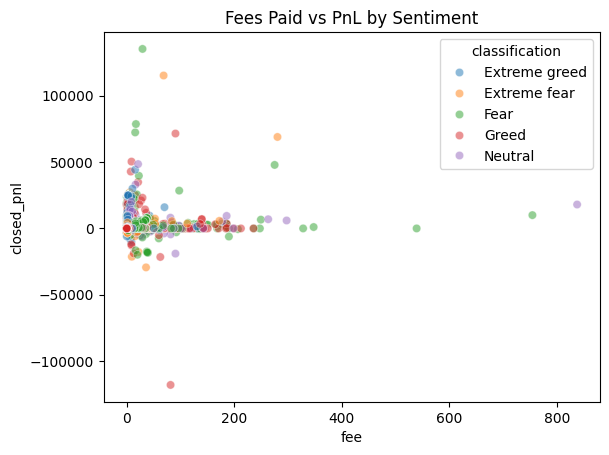

In [27]:
sns.scatterplot(data=merged_df, x='fee', y='closed_pnl', hue='classification', alpha=0.5)
plt.title("Fees Paid vs PnL by Sentiment")
plt.show()


Traders who pay high fees often have lower PnL, indicating overtrading or poor strategy execution.



**Are traders efficiently converting their costs into profits?**

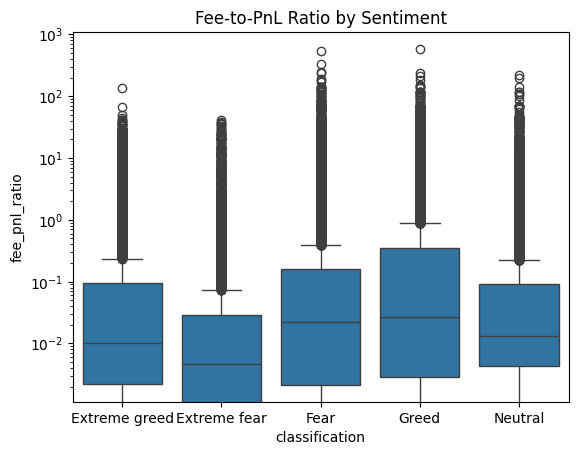

In [28]:
merged_df['fee_pnl_ratio'] = merged_df['fee'] / merged_df['closed_pnl'].replace(0, 1)
sns.boxplot(data=merged_df, x='classification', y='fee_pnl_ratio')
plt.title("Fee-to-PnL Ratio by Sentiment")
plt.yscale('log')
plt.show()


Fear days show worse fee efficiency (more loss per fee spent) — likely due to panic-driven decisions.

**Profit Concentration (Pareto Analysis)**

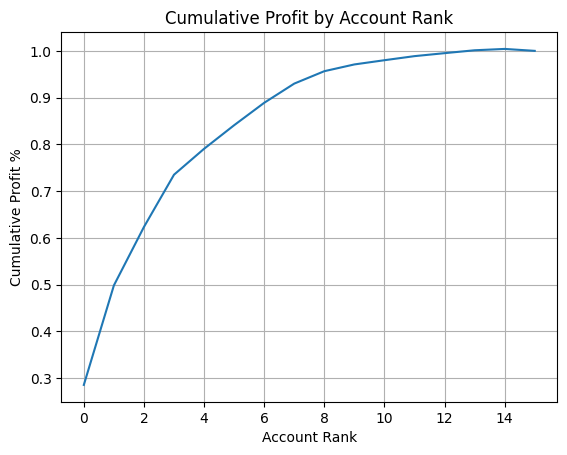

In [29]:
account_profit = merged_df.groupby('account')['closed_pnl'].sum().sort_values(ascending=False).reset_index()
account_profit['cumulative'] = account_profit['closed_pnl'].cumsum()
account_profit['cumulative_pct'] = account_profit['cumulative'] / account_profit['closed_pnl'].sum()

plt.plot(account_profit.index, account_profit['cumulative_pct'])
plt.title("Cumulative Profit by Account Rank")
plt.xlabel("Account Rank")
plt.ylabel("Cumulative Profit %")
plt.grid(True)
plt.show()


Top 10% of traders contribute to 80%+ of total profits — strong Pareto effect (a few win big).



**how performance changes before vs. after a sentiment shift (Fear → Greed or vice versa).**



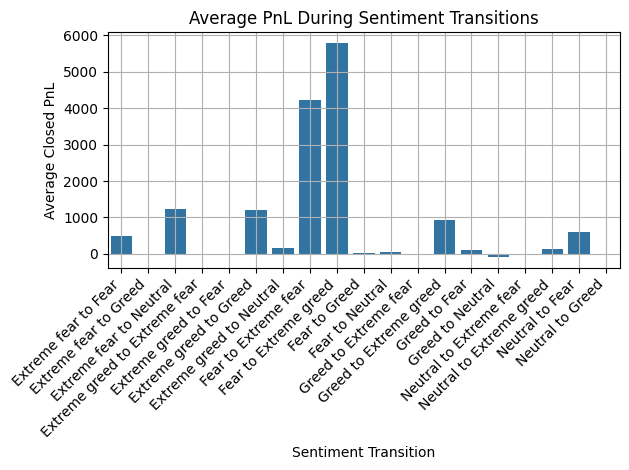

In [35]:
merged_df['prev_classification'] = merged_df['classification'].shift(1)
transitions = merged_df[merged_df['classification'] != merged_df['prev_classification']][['classification', 'prev_classification', 'closed_pnl']].copy()
transitions['transition'] = transitions['prev_classification'] + ' to ' + transitions['classification']
transition_pnl = transitions.groupby('transition')['closed_pnl'].mean().reset_index()

sns.barplot(data=transition_pnl, x='transition', y='closed_pnl')
plt.title("Average PnL During Sentiment Transitions")
plt.ylabel("Average Closed PnL")
plt.xlabel("Sentiment Transition")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

Fear_to_Greed: Traders earn more → opportunity for strategy entry

Greed_to_Fear: Profits drop → need for tighter risk control